In [27]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel

In [28]:
housing = pd.read_csv('../../data/housing-classification-iter-0-2.csv')
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotArea       1460 non-null   int64  
 1   LotFrontage   1201 non-null   float64
 2   TotalBsmtSF   1460 non-null   int64  
 3   BedroomAbvGr  1460 non-null   int64  
 4   Fireplaces    1460 non-null   int64  
 5   PoolArea      1460 non-null   int64  
 6   GarageCars    1460 non-null   int64  
 7   WoodDeckSF    1460 non-null   int64  
 8   ScreenPorch   1460 non-null   int64  
 9   Expensive     1460 non-null   int64  
dtypes: float64(1), int64(9)
memory usage: 114.2 KB


In [29]:
housing.head()

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive
0,8450,65.0,856,3,0,0,2,0,0,0
1,9600,80.0,1262,3,1,0,2,298,0,0
2,11250,68.0,920,3,1,0,2,0,0,0
3,9550,60.0,756,3,1,0,3,0,0,0
4,14260,84.0,1145,4,1,0,3,192,0,0


In [30]:
# Most frequent bedroom quantity:
housing.BedroomAbvGr.value_counts()

3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

In [31]:
housing.GarageCars.value_counts()

2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

In [32]:
housing.Fireplaces.value_counts()

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

### Data quality check

In [33]:
# Missing values:
housing.isna().sum()

LotArea           0
LotFrontage     259
TotalBsmtSF       0
BedroomAbvGr      0
Fireplaces        0
PoolArea          0
GarageCars        0
WoodDeckSF        0
ScreenPorch       0
Expensive         0
dtype: int64

In [34]:
# Duplicated rows:
housing.duplicated().sum()

14

In [35]:
housing.groupby(['Fireplaces', 'TotalBsmtSF', 'Expensive']).agg(count=('Expensive', 'count'))

count
Fireplaces TotalBsmtSF Expensive       
0          0           0             28
           105         0              1
           190         0              1
           264         0              1
           270         0              1
...                                 ...
3          768         0              1
           1617        0              1
           1896        1              1
           1952        1              1
           6110        0              1

[984 rows x 1 columns]

In [36]:
from sklearn.model_selection import train_test_split

X = housing.drop(columns=['Expensive'], axis=1)
y = housing['Expensive']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=8)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [37]:
train_house = (
    X_train
    .assign(Expensive = y_train)
    .groupby(['Fireplaces', 'TotalBsmtSF', 'Expensive'])
    .agg(count = ('Expensive', 'count'))
)
train_house

count
Fireplaces TotalBsmtSF Expensive       
0          0           0             22
           105         0              1
           190         0              1
           264         0              1
           270         0              1
...                                 ...
3          768         0              1
           1617        0              1
           1896        1              1
           1952        1              1
           6110        0              1

[774 rows x 1 columns]

# Create the dummy model ("Train")

In [38]:
def my_dummy_model(row): 
    if (row.Fireplaces <= 1): 
        return 0
    elif(row.TotalBsmtSF == 0):
        return 0
    elif(row.TotalBsmtSF > 1300):
        return 1
    elif (row.Fireplaces > 1):
        return 1

housing['pred'] = [my_dummy_model(row) for i, row in housing.iterrows()]
housing.head()

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive,pred
0,8450,65.0,856,3,0,0,2,0,0,0,0
1,9600,80.0,1262,3,1,0,2,298,0,0,0
2,11250,68.0,920,3,1,0,2,0,0,0,0
3,9550,60.0,756,3,1,0,3,0,0,0,0
4,14260,84.0,1145,4,1,0,3,192,0,0,0


## Evaluate my model

In [39]:
error_check = housing.filter(['Expensive', 'pred']).assign(check = lambda x: x['Expensive'] == x['pred'])
error_check.sample(10)

,Expensive,pred,check
611,0,0,True
95,0,0,True
1376,0,0,True
1372,1,0,False
1101,0,0,True
257,0,0,True
423,1,0,False
1177,0,0,True
224,1,0,False
985,0,0,True


In [40]:
error_check['check'].sum()

1202

In [41]:
error_check['check'].sum() / error_check.shape[0]

0.8232876712328767

In [42]:
housing.drop(columns=['pred'], inplace=True)

## Test the model

In [43]:
X_train['pred'] = [my_dummy_model(row) for i, row in X_train.iterrows()] 
X_test['pred'] = [my_dummy_model(row) for i, row in X_test.iterrows()]

In [44]:
# results train data:
(
    pd.DataFrame({
        'Expensive': y_train,
        'pred' : X_train['pred']
        })
    .assign(check = lambda x: x['Expensive'] == x['pred'])['check']
    .sum()
) / len(y_train)

0.821917808219178

In [45]:
# results test data:
acc_2nd = (
    pd.DataFrame({
        'Expensive': y_test,
        'pred': X_test['pred']
        })
    .assign(check = lambda x: x['Expensive'] == x['pred'])['check']
    .sum()
) / len(y_test)
acc_2nd

0.8273972602739726

# Simple imputer

In [46]:
X_train.isna().sum()

LotArea           0
LotFrontage     188
TotalBsmtSF       0
BedroomAbvGr      0
Fireplaces        0
PoolArea          0
GarageCars        0
WoodDeckSF        0
ScreenPorch       0
pred              0
dtype: int64

Using simple imputer will fill the missing values in the dataset

In [47]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean")
imputer.fit(X_train[['LotFrontage']])
X_train['LotFrontage'] = imputer.transform(X_train[['LotFrontage']])
X_test['LotFrontage'] = imputer.transform(X_test[['LotFrontage']])

## Decision tree

In [48]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

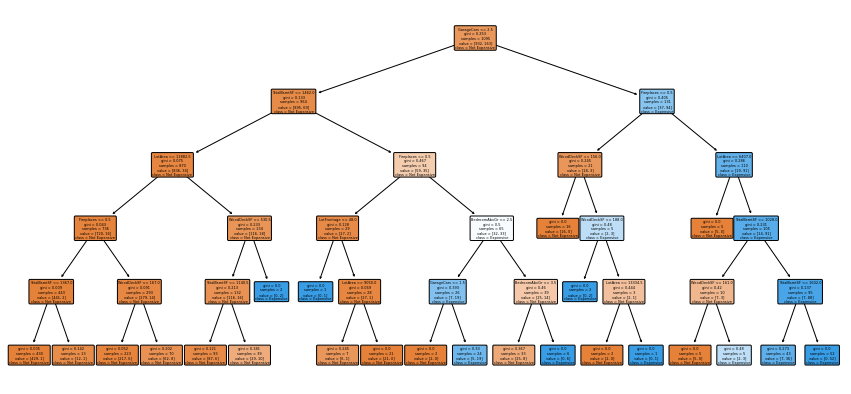

In [49]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize = (15, 7))
plot_tree(
    tree, 
    filled=True,
    rounded=True,
    class_names=['Not Expensive', 'Expensive'], 
    feature_names=X_train.columns
    )
plt.show()

Checking the accuracy of the train (1st) and test (2nd)

In [50]:
from sklearn.metrics import accuracy_score
preds=tree.predict(X_train)
accuracy_score(preds, y_train)

0.9497716894977168

In [51]:
preds=tree.predict(X_test)
decision_imputed=accuracy_score(preds, y_test)
decision_imputed

0.9123287671232877

C:\Users\akbar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


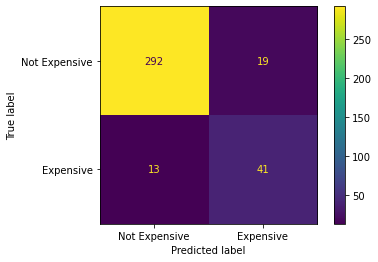

In [52]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(tree, X_test, y_test, display_labels=['Not Expensive', 'Expensive'])
plt.show()

# OneHotEncoder

Creating a decision tree. Use only the column Fireplaces as a predictor:

In [53]:
import pandas as pd
housing_itr3 = pd.read_csv('../../data/housing-classification-iter3.csv')
housing_itr3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotArea       1460 non-null   int64  
 1   LotFrontage   1201 non-null   float64
 2   TotalBsmtSF   1460 non-null   int64  
 3   BedroomAbvGr  1460 non-null   int64  
 4   Fireplaces    1460 non-null   int64  
 5   PoolArea      1460 non-null   int64  
 6   GarageCars    1460 non-null   int64  
 7   WoodDeckSF    1460 non-null   int64  
 8   ScreenPorch   1460 non-null   int64  
 9   Expensive     1460 non-null   int64  
 10  MSZoning      1460 non-null   object 
 11  Condition1    1460 non-null   object 
 12  Heating       1460 non-null   object 
 13  Street        1460 non-null   object 
 14  CentralAir    1460 non-null   object 
 15  Foundation    1460 non-null   object 
dtypes: float64(1), int64(9), object(6)
memory usage: 182.6+ KB


In [54]:
housing_itr3.head(3)

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive,MSZoning,Condition1,Heating,Street,CentralAir,Foundation
0,8450,65.0,856,3,0,0,2,0,0,0,RL,Norm,GasA,Pave,Y,PConc
1,9600,80.0,1262,3,1,0,2,298,0,0,RL,Feedr,GasA,Pave,Y,CBlock
2,11250,68.0,920,3,1,0,2,0,0,0,RL,Norm,GasA,Pave,Y,PConc


### Check the metrics on train

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

X = housing_itr3.drop(columns=['Expensive'], axis=1)
y = housing_itr3['Expensive']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=8)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [56]:
train_house2 = X_train.assign(Expensive = y_train)
train_house2.head()

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,MSZoning,Condition1,Heating,Street,CentralAir,Foundation,Expensive
703,7630,76.0,360,4,1,0,2,344,0,RM,Feedr,GasA,Pave,Y,BrkTil,0
1207,9135,70.0,1682,3,0,0,2,192,0,RL,Norm,GasA,Pave,Y,PConc,0
779,10530,78.0,975,2,0,0,2,0,0,RL,Norm,GasA,Pave,Y,CBlock,0
441,12108,92.0,1440,4,0,0,0,0,0,RL,Norm,GasA,Pave,N,CBlock,0
249,159000,NaN,1444,4,2,0,2,0,0,RL,Norm,GasA,Pave,Y,CBlock,1


In [57]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train[['LotFrontage']])
X_train['LotFrontage'] = imputer.transform(X_train[['LotFrontage']])
X_test['LotFrontage'] = imputer.transform(X_test[['LotFrontage']])

In [58]:
categoric_features = list(X_train.select_dtypes(include=["object"]))
numeric_features = list(X_train.select_dtypes(exclude=["object"]))

In [59]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(drop = 'first', sparse = False)
enc.fit(X_train[categoric_features])

OneHotEncoder(drop='first', sparse=False)

In [60]:
X_train_enc = enc.transform(X_train[categoric_features])
X_train_enc = pd.DataFrame(X_train_enc, columns=list(enc.get_feature_names_out()), index=X_train.index)
X_train = pd.concat([X_train, X_train_enc], axis=1, ignore_index=False).drop(columns=categoric_features)

In [61]:
X_test_enc = enc.transform(X_test[categoric_features])
X_test_enc = pd.DataFrame(X_test_enc, columns=list(enc.get_feature_names_out()), index=X_test.index)
X_test = pd.concat([X_test, X_test_enc], axis=1, ignore_index=False).drop(columns=categoric_features)

## Train the model

In [62]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=9)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9)

## Visualise the model

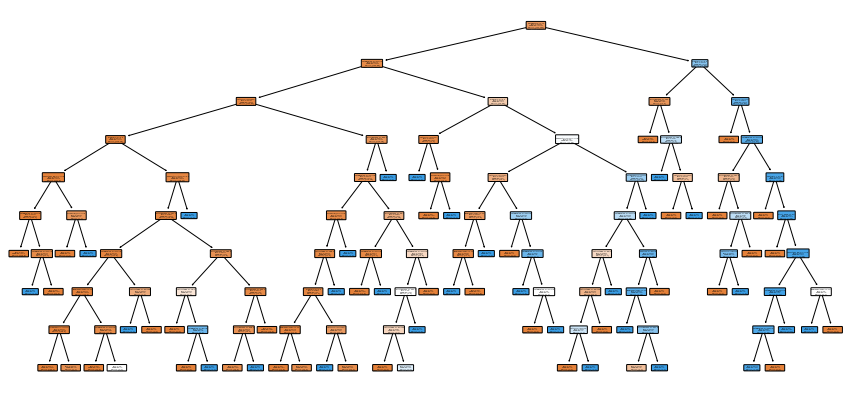

In [63]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(15, 7))
plot_tree(
    tree, 
    filled=True,
    rounded=True,
    class_names=['Not Expensive', 'Expensive'],
    feature_names=X_train.columns
    );

## Test own model

In [64]:
from sklearn.metrics import accuracy_score

#accuracy train set:
preds = tree.predict(X_train)
accuracy_score(preds, y_train)

0.982648401826484

In [65]:
# accuracy test set:

preds = tree.predict(X_test)
decision_hotencoded = accuracy_score(preds, y_test)
decision_hotencoded

0.9013698630136986

## Confusion matrix

Another way to visualise our errors is to use a confusion matrix:

C:\Users\akbar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


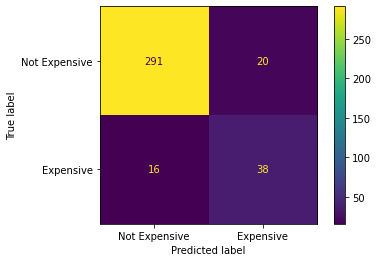

In [66]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(tree, X_test, y_test, display_labels=['Not Expensive', 'Expensive']);

# Scikit-learn pipeline

In [67]:
X = housing_itr3.drop(columns=['Expensive'])
y = housing_itr3['Expensive']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state=8)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [68]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(drop='first', sparse=False))
])

In [69]:
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(transformers = [
    ('number', numeric_pipeline, numeric_features),
    ('category', categorical_pipeline, categoric_features)
])


In [70]:
tree_pipeline = Pipeline(steps = [
    ('preprocess', full_processor), 
    ('model', DecisionTreeClassifier())
])
tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['LotArea', 'LotFrontage',
                                                   'TotalBsmtSF',
                                                   'BedroomAbvGr', 'Fireplaces',
                                                   'PoolArea', 'GarageCars',
                                                   'WoodDeckSF',
                                                   'ScreenPorch']),
                                                 ('category',
                                                  Pipeline(steps=[('impute',
            

In [71]:
accuracy_score(tree_pipeline.predict(X_train), y_train)

1.0

In [72]:
preds = tree_pipeline.predict(X_test)
decision_tree_pipeline = accuracy_score(preds, y_test)
decision_tree_pipeline

0.8876712328767123

C:\Users\akbar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


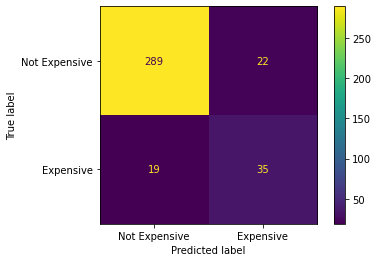

In [73]:
plot_confusion_matrix(tree_pipeline, X_test, y_test, display_labels=['Not Expensive', 'Expensive']);

## Preprocess (clean code)

In [74]:
# numerical and categorical pipeline
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])
categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(drop='first', sparse=False))
])

# automating the column selection
full_processor = ColumnTransformer(transformers = [
    ('number', numeric_pipeline, numeric_features),
    ('category', categorical_pipeline, categoric_features)
])

## Manually tuning the model

In [75]:
# adding the model in our pipeline
tree_pipeline = Pipeline(steps=[
    ('preprocess', full_processor), 
    ('model', DecisionTreeClassifier(max_depth=9))
])
# fit our model to the train
tree_pipeline.fit(X_train, y_train)
accuracy_score(tree_pipeline.predict(X_train), y_train)

0.982648401826484

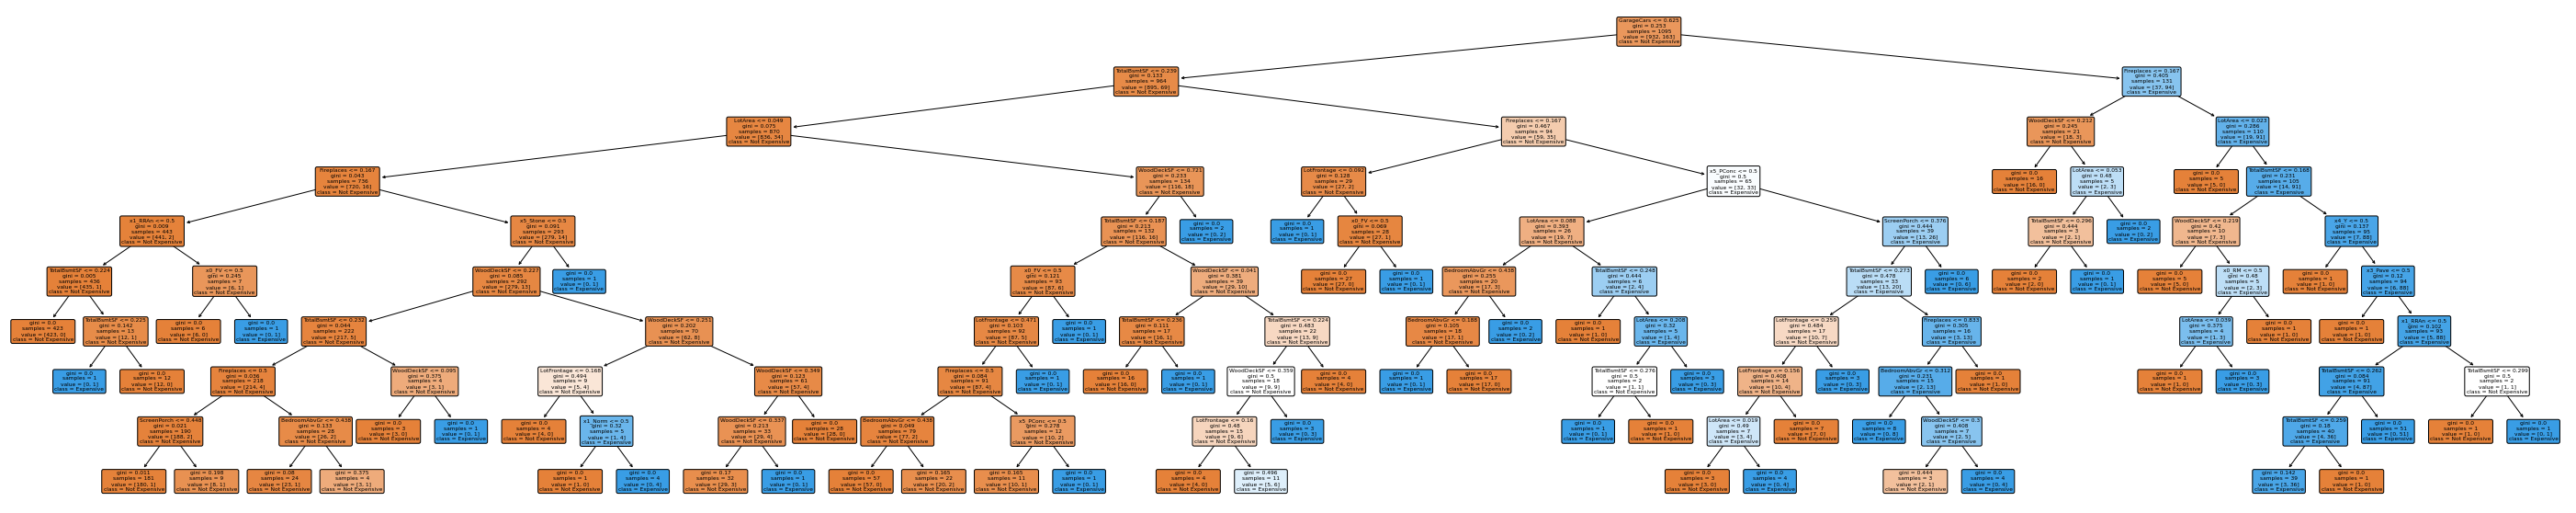

In [76]:
# get column names
col_names = numeric_features.copy()
col_names.extend(
    tree_pipeline.named_steps['preprocess'].transformers_[1][1].named_steps['one-hot'].get_feature_names_out()
)

plt.figure(figsize=(50, 10))
plot_tree(
    tree_pipeline['model'],
    filled=True,
    rounded=True,
    feature_names=col_names,
    class_names=['Not Expensive', 'Expensive']
    );

In [77]:
preds = tree_pipeline.predict(X_test)
decision_tuning = accuracy_score(preds, y_test)
decision_tuning

0.8958904109589041

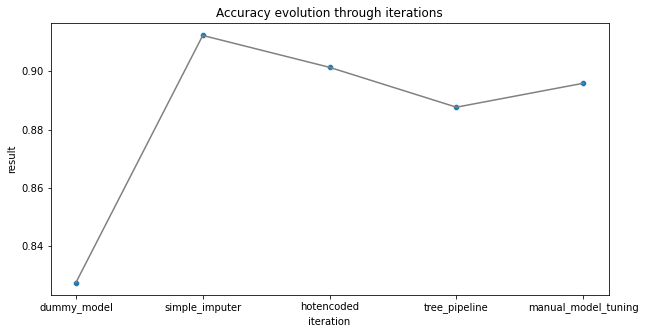

In [78]:
import seaborn as sns 

# Check if the model has improved:
plt.subplots(figsize=(10, 5))
results = pd.DataFrame({
    'iteration': ['dummy_model','simple_imputer', 'hotencoded', 'tree_pipeline', 'manual_model_tuning'],
    'result': [acc_2nd, decision_imputed, decision_hotencoded, decision_tree_pipeline, decision_tuning]
})
sns.lineplot(data=results, x='iteration', y='result', color='grey')
sns.scatterplot(data=results, x='iteration', y='result')
plt.title('Accuracy evolution through iterations');

# Auto model tuning + cross validation

In [57]:
# numerical and categorical pipeline
numeric_pipeline = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])
categorical_pipeline = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(drop='first', sparse=False))
])

# automating the column selection
full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numeric_features), 
    ('category', categorical_pipeline, categoric_features)
])

# adding the model in our pipeline
tree_pipeline = Pipeline(steps=[
    ('preprocess', full_processor), 
    ('model', DecisionTreeClassifier())
])
# automating the search of the different parameters for our model
from sklearn.model_selection import GridSearchCV
param_grid = {
    'model__max_depth': range(1, 8),
    'model__min_samples_leaf': range(1, 10),
    'model__min_samples_split': range(2, 10),
    'model__criterion':['gini','entropy']
    }
search = GridSearchCV(
    tree_pipeline, 
    param_grid, 
    cv=10,
    scoring='accuracy', 
    verbose=1, 
    refit=True, 
    n_jobs=-1
    )
# fit our model to the train
gds = search.fit(X_train, y_train)

Fitting 10 folds for each of 1008 candidates, totalling 10080 fits


C:\Users\akbar\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


In [58]:
search.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 1,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2}

In [59]:
accuracy_score(search.predict(X_train), y_train)

0.9031963470319635

In [60]:
# accuracy of the test:
decision_am_cv = accuracy_score(search.predict(X_test), y_test)
decision_am_cv

0.8931506849315068

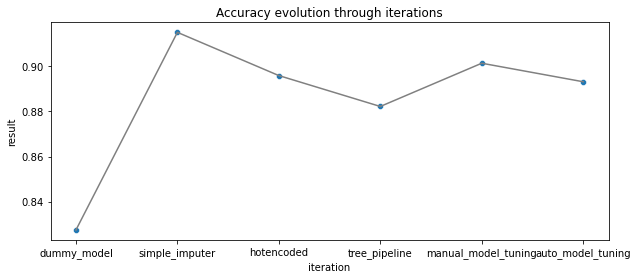

In [61]:
plt.figure(figsize=(10, 4))
results = results.append({'iteration':'auto_model_tuning', 'result': decision_am_cv}, ignore_index=True)
sns.lineplot(data=results, x='iteration', y='result', color='grey')
sns.scatterplot(data=results, x='iteration', y='result')
plt.title('Accuracy evolution through iterations');

# Ordinal Encoding

In [68]:
housing_itr4 = pd.read_csv('../../data/housing-classification-iter4.csv')
housing_itr4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotArea       1460 non-null   int64  
 1   LotFrontage   1201 non-null   float64
 2   TotalBsmtSF   1460 non-null   int64  
 3   BedroomAbvGr  1460 non-null   int64  
 4   Fireplaces    1460 non-null   int64  
 5   PoolArea      1460 non-null   int64  
 6   GarageCars    1460 non-null   int64  
 7   WoodDeckSF    1460 non-null   int64  
 8   ScreenPorch   1460 non-null   int64  
 9   Expensive     1460 non-null   int64  
 10  MSZoning      1460 non-null   object 
 11  Condition1    1460 non-null   object 
 12  Heating       1460 non-null   object 
 13  Street        1460 non-null   object 
 14  CentralAir    1460 non-null   object 
 15  Foundation    1460 non-null   object 
 16  ExterQual     1460 non-null   object 
 17  ExterCond     1460 non-null   object 
 18  BsmtQual      1423 non-null 

In [69]:
X=housing_itr4.drop('Expensive',axis=1)
y=housing_itr4['Expensive']

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.75, random_state=8)
X_train = pd.DataFrame(X_train,columns=X.columns)
X_test = pd.DataFrame(X_test,columns=X.columns)

In [70]:
housing_itr4_train = X_train.assign(Expensive = y_train)

In [76]:
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])
categorical_pipeline = Pipeline(steps=[
    ('impute',SimpleImputer(strategy='constant',fill_value='Have_0')),
    ('ordinal', OrdinalEncoder())
])

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numeric_features), 
    ('category', categorical_pipeline, categoric_features)
])

tree_pipeline = Pipeline(steps=[
    ('preprocess', full_processor), 
    ('model', DecisionTreeClassifier())
])

param_grid = {
    'model__max_depth': range(1, 8),
    'model__min_samples_leaf': range(1, 10),
    'model__min_samples_split': range(2, 10),
    'model__criterion':['gini','entropy']
    }

search = GridSearchCV(
    tree_pipeline, 
    param_grid, 
    cv=15,
    scoring='accuracy', 
    verbose=1, 
    refit=True, 
    n_jobs=-1
    )

_ = search.fit(X_train, y_train)

Fitting 15 folds for each of 1008 candidates, totalling 15120 fits


C:\Users\akbar\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


In [77]:
accuracy_score(search.predict(X_train), y_train)

0.9031963470319635

In [78]:
# accuracy of the test:
decision_ordinal_enc = accuracy_score(search.predict(X_test), y_test)
decision_ordinal_enc

0.8931506849315068

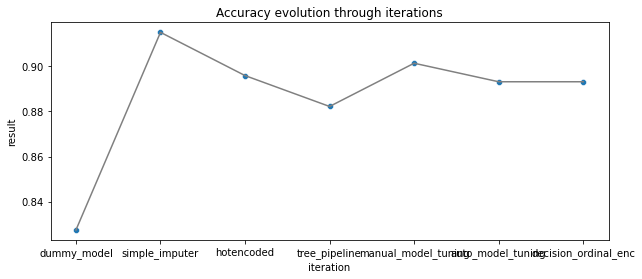

In [79]:
plt.figure(figsize=(10, 4))
results = results.append({'iteration':'decision_ordinal_enc', 'result': decision_ordinal_enc}, ignore_index=True)
sns.lineplot(data=results, x='iteration', y='result', color='grey')
sns.scatterplot(data=results, x='iteration', y='result')
plt.title('Accuracy evolution through iterations');

# Iteration 7: Regression

In [145]:
import pandas as pd
housing7 = pd.read_csv('../../data/iter-7/housing_prices.csv')
housing7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [84]:
X = housing7.drop(columns=['SalePrice'])
y = housing7['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state= 8 )

## Creating dummy model

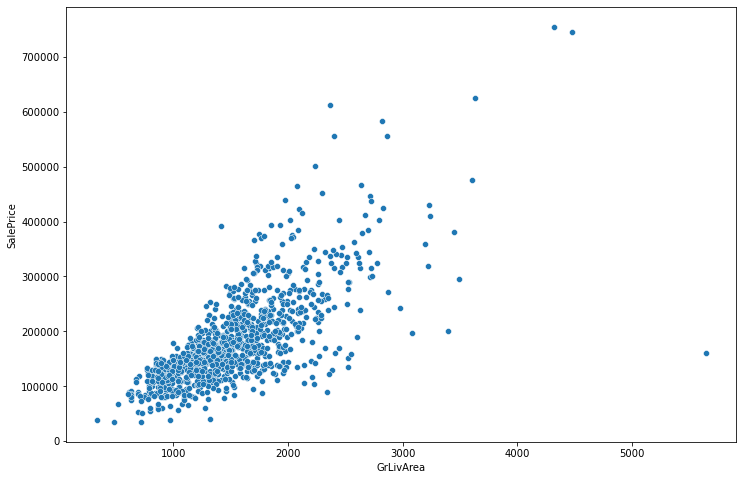

In [85]:
plt.subplots(figsize=(12, 8))
sns.scatterplot(x=X_train['GrLivArea'], y=y_train)
plt.show()

In [86]:
def my_dummy_model(GrLivArea):
    return GrLivArea * 100

dummy_model = (
X_train
    .assign(
        preds = lambda x: my_dummy_model(x['GrLivArea']), 
        price = y_train
        )
    .assign(
        error = lambda x: x['preds'] - x['price']
    )
)
dummy_model

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,preds,price,error
703,704,190,RM,76.0,7630,Pave,NaN,Reg,Lvl,AllPub,...,MnPrv,NaN,0,5,2010,WD,Normal,181200,140000,41200
1207,1208,20,RL,70.0,9135,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,5,2006,WD,Normal,170000,200000,-30000
779,780,90,RL,78.0,10530,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,5,2006,WD,Normal,100400,135000,-34600
441,442,90,RL,92.0,12108,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,9,2008,WD,Normal,144000,118000,26000
249,250,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,...,NaN,Shed,500,6,2007,WD,Normal,214400,277000,-62600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,987,50,RM,59.0,5310,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,6,2006,WD,Normal,163500,117000,46500
133,134,20,RL,NaN,6853,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,6,2009,WD,Normal,129600,220000,-90400
361,362,50,RL,NaN,9144,Pave,Pave,Reg,Lvl,AllPub,...,NaN,NaN,0,7,2008,WD,Normal,150500,145000,5500
1364,1365,160,FV,30.0,3180,Pave,Pave,Reg,Lvl,AllPub,...,NaN,NaN,0,4,2006,WD,Abnorml,120000,144152,-24152


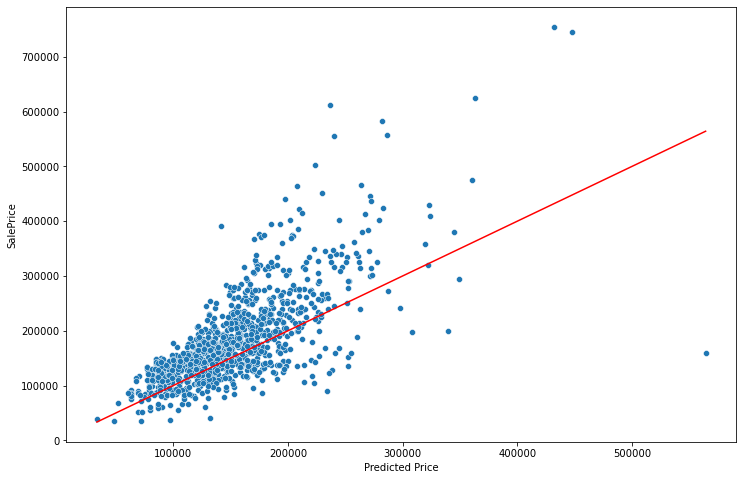

In [87]:
def plot_predictions(y_true, y_pred):
    #limit of the visualisation
    max_preds = min([max(y_pred.tolist()), max(y_true.tolist())])
    min_preds = min([min(y_pred.tolist()), min (y_true.tolist())])
    #plotting the graph
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=y_pred, y=y_true)
    sns.lineplot(x=[min_preds, max_preds], y=[min_preds, max_preds], color = 'red')
    plt.ylabel('SalePrice')
    plt.xlabel('Predicted Price')
    plt.show()
plot_predictions(dummy_model['price'], dummy_model['preds'])

## Creating Linear Model

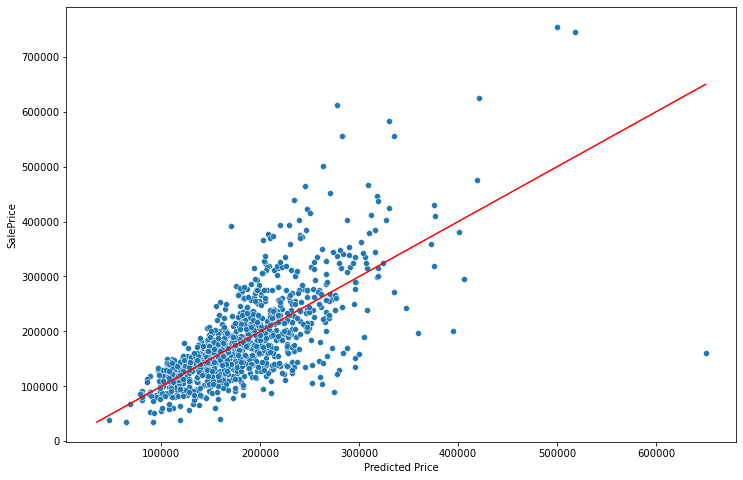

In [88]:
lin_model = LinearRegression()
lin_model.fit(np.array(X_train['GrLivArea']).reshape(-1, 1), y_train)
plot_predictions(y_train, lin_model.predict(np.array(X_train['GrLivArea']).reshape(-1, 1)))

In [89]:
print(lin_model.coef_, lin_model.intercept_)

[113.55080556] 9413.700331229455


Linear model: 

$$
price = 9413.700331229455 + GrLivArea * 113.55080556
$$

## Test set implementation

In [90]:
results = pd.DataFrame({
    'prediction' : lin_model.predict(np.array(X_test['GrLivArea']).reshape(-1, 1)), 
    'true_value' : y_test
})
results.head()

,prediction,true_value
1260,199611.299649,181000
274,102071.157671,124500
51,142949.447673,114500
117,137158.356590,155000
789,246394.231541,187500


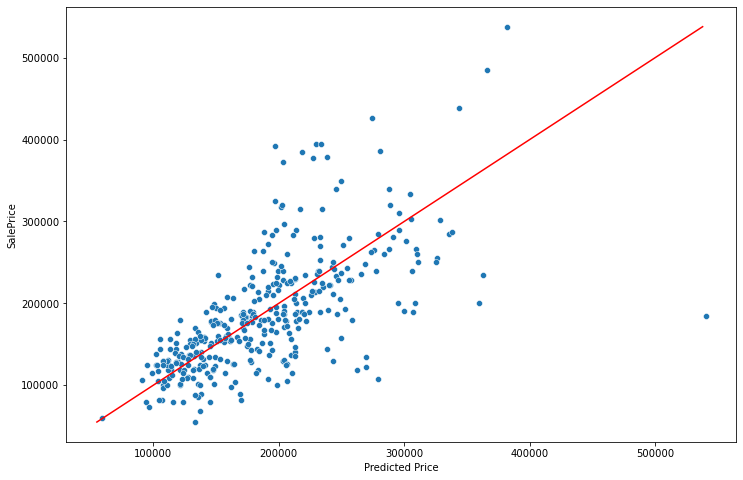

In [91]:
plot_predictions(results.true_value, results.prediction)

### Mean Squared Error (MSE): is calculated as the mean or average of the squared differences between predicted and expected target values.
$$MSE = \frac{1}{n}\sum_{i=1}^{n}(y_{i} - y_{e})^{2}$$

In [92]:
mse_pre = (results
              .assign(diff = lambda x: (x.true_value - x.prediction)**2)
              .agg({'diff':{'sum', 'count'}}))
mse = mse_pre.loc['sum'] / mse_pre.loc['count']
mse

diff    3.100773e+09
dtype: float64

In [93]:
mse_pre = (results.assign(diff = lambda x: (x.true_value - x.prediction)**2).agg({'diff':{'sum','count'}}))
mse_pre

,diff
sum,1.131782e+12
count,3.650000e+02


* sklearn metrics

In [94]:
from sklearn.metrics import mean_squared_error
mean_squared_error(results.true_value, results.prediction)

3100772532.6307178

### Root Mean Squared Error (RMSE): 
$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_{i} - y_{e})^{2}}$$

In [95]:
rmse = (mse_pre.loc['sum'] / mse_pre.loc['count'])**0.5
rmse

diff    55684.580744
dtype: float64

### Mean Absolute Error (MAE)
$$MAE = \frac{1}{n}\sum_{i=1}^{n} |y_{i} - y_{e}|$$

In [96]:
mae_pre = (results
              .assign(diff = lambda x: abs(x.true_value- x.prediction))
              .agg({'diff':{'sum', 'count'}})
)
mae = mae_pre.loc['sum'] / mae_pre.loc['count']
mae

diff    38312.646876
dtype: float64

* sklearn metrics

In [97]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(results.true_value, results.prediction)

38312.64687646077

### Mean Absolute Percentage Error (MAPE)

$$MAPE = \frac{1}{n}\sum_{i=1}^{n} |\frac{y_{i} - y_{e}}{y_{i}}|$$

In [98]:
mape_pre = (results
              .assign(diff = lambda x: abs((x.true_value- x.prediction) / x.true_value))
              .agg({'diff':{'sum', 'count'}})
)
mape = mape_pre.loc['sum'] / mape_pre.loc['count']
mape

diff    0.220148
dtype: float64

* sklearn metrics

In [99]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(results.true_value, results.prediction)

0.2201483782234101


        MSE: 3100772532.6307178
        RMSE: 55684.58074396105
        MAE: 38312.64687646077
        
538000 59148.95316781597


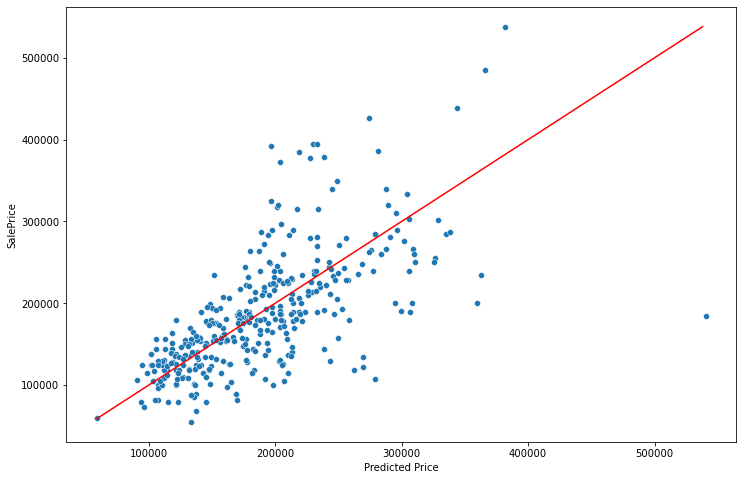

In [100]:
def plot_predictions(y_true, y_pred):
    print(f"""
        MSE: {mean_squared_error(y_true, y_pred)}
        RMSE: {mean_squared_error(y_true, y_pred)**0.5}
        MAE: {mean_absolute_error(y_true, y_pred)}
        """
)
    #limit of the visualisation
    max_preds = min([max(y_pred.tolist()), max(y_true.tolist())])
    min_preds = max([min(y_pred.tolist()), min(y_true.tolist())])
    print(max_preds, min_preds)
    #plot
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=y_pred, y=y_true)
    sns.lineplot(x=[min_preds, max_preds], y=[min_preds, max_preds], color = 'red')
    plt.ylabel('SalePrice')
    plt.xlabel('Predicted Price')
    plt.show()
plot_predictions(y_test, results['prediction'])

#### Check normal distribution:

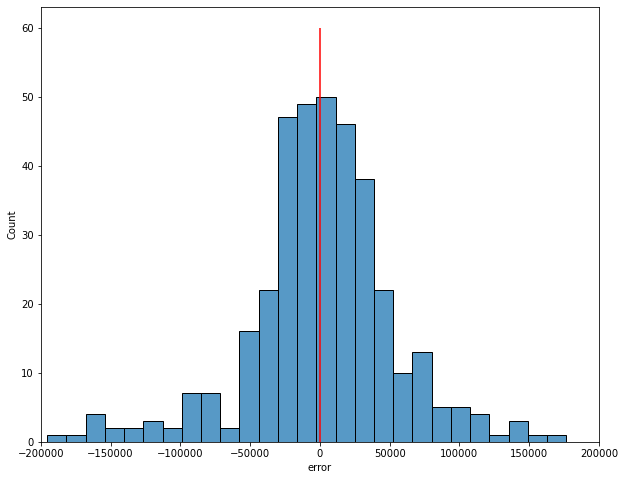

In [101]:
p_df = results.assign(error = lambda x: x['prediction'] - x['true_value'])

plt.subplots(figsize=(10, 8))
sns.histplot(p_df['error'])
plt.vlines(x=0, ymin=0, ymax=60, color='red')
plt.xlim(-200000, 200000)
plt.show()

No skewness, model might predict correct prices

<AxesSubplot:xlabel='error', ylabel='Count'>

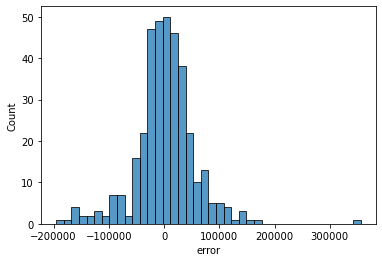

In [102]:
p = sns.histplot(p_df['error'])
p

#### Different approach to error visualisation:

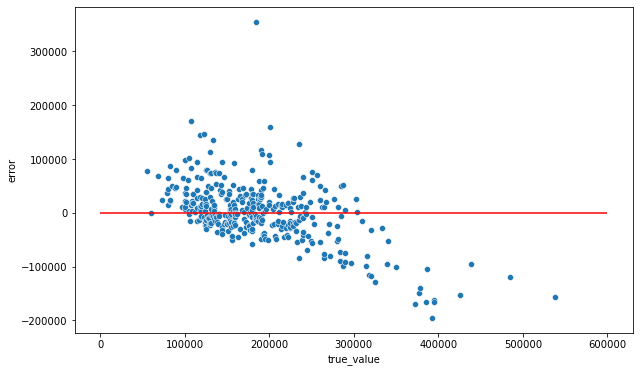

In [103]:
p_df = p_df.sort_values(by='true_value')

plt.subplots(figsize=(10, 6))
sns.scatterplot(data = p_df, x = 'true_value', y = 'error')
plt.hlines(y = 0, xmin = 0, xmax = 600000, color = 'red')
plt.show()

# Iteration 8: Sklearn pipeline + all features

In [104]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

cat_pipeline = Pipeline(steps=[
    ('one_hot_enc', OneHotEncoder(drop='first'))
])

num_pipeline = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

categoric_features = list(X_train.select_dtypes(include=["object"]))
numeric_features = list(X_train.select_dtypes(exclude=["object"]))
full_processor = ColumnTransformer(transformers=[
    ('number', num_pipeline, numeric_features), 
    ('category', cat_pipeline, categoric_features)
])

lin_model_pipeline = Pipeline(steps=[
    ('processor', full_processor), 
    ('model', LinearRegression())
])

cp = lin_model_pipeline.fit(X_train, y_train)


        MSE: 335682807.6573321
        RMSE: 18321.648606425464
        MAE: 12451.879857454234
        
744999.9360095002 34900


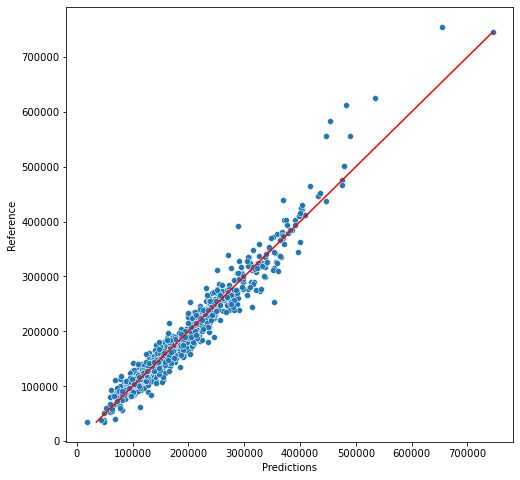

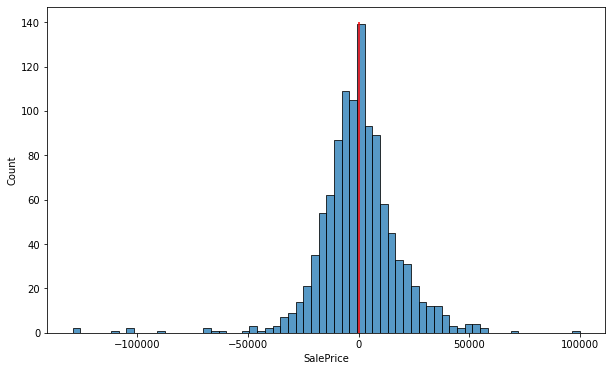

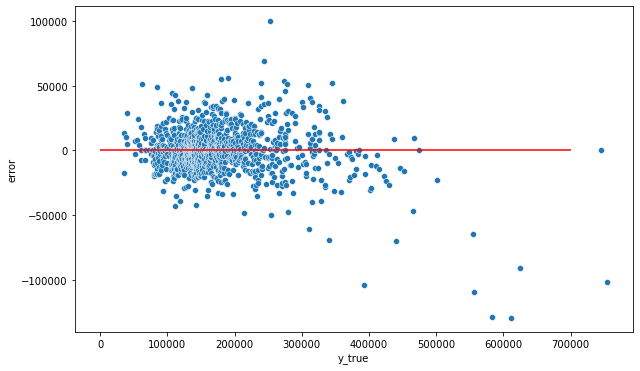

In [149]:
def plot_predictions(y_true, y_pred):
    print(
        f"""
        MSE: {mean_squared_error(y_true, y_pred)}
        RMSE: {mean_squared_error(y_true, y_pred)**0.5}
        MAE: {mean_absolute_error(y_true, y_pred)}
        """
    )
    max_preds = min([max(y_pred.tolist()), max(y_true.tolist())])
    min_preds = max([min(y_pred.tolist()), min(y_true.tolist())])
    print(max_preds, min_preds)
    # plot
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=y_pred, y=y_true)
    sns.lineplot(x=[min_preds,max_preds], y=[min_preds, max_preds], color='red')
    plt.ylabel('Reference')
    plt.xlabel('Predictions')
    plt.show()
    
    errors = y_pred - y_true
    plt.subplots(figsize=(10, 6))
    sns.histplot(errors)
    plt.vlines(x = 0, ymin = 0, ymax = 140, color = 'red')
    plt.show()
    
    p_df = (
        pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
        .assign(error = lambda x: x['y_pred'] - x['y_true'])
        .sort_values(by = 'y_true')
        )
    
    plt.subplots(figsize = (10, 6))
    sns.scatterplot(data=p_df, x = 'y_true', y = 'error')
    plt.hlines(y = 0, xmin = 0, xmax = 700000, color = 'red')
    plt.show()
    
plot_predictions(y_train, lin_model_pipeline.predict(X_train))
#plot_predictions(y_test, results['prediction'])

# Correlation matrix:

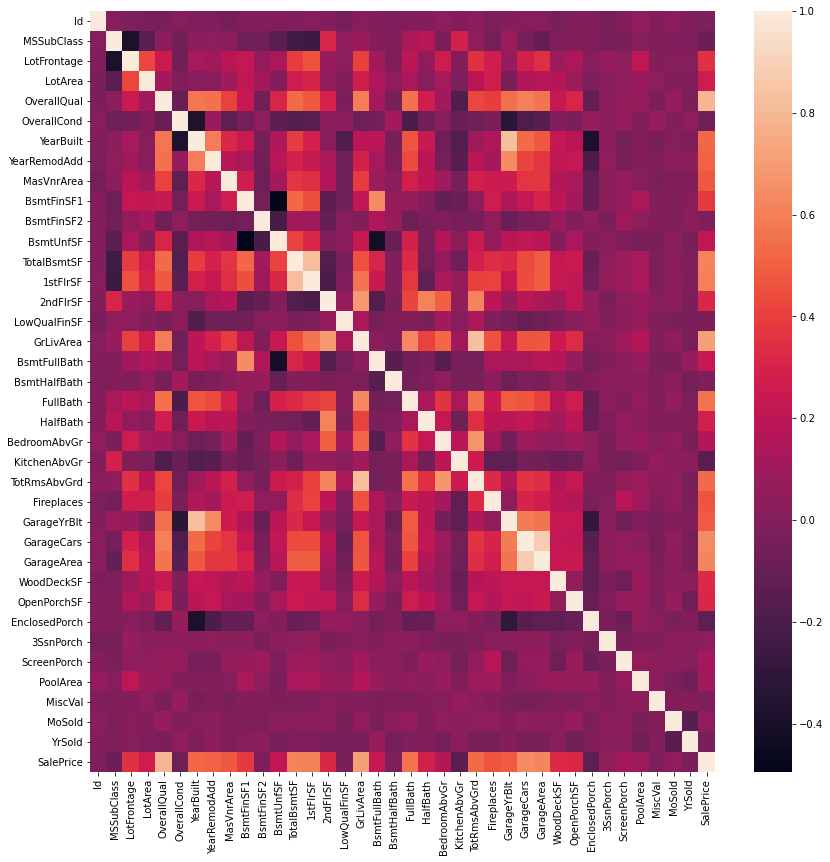

In [146]:
import seaborn as sn
import matplotlib.pyplot as plt
 
fig, ax = plt.subplots(figsize=(14,14))
sn.heatmap(housing7.corr());

In [147]:
def select_cols_corr(df_corr, target_col, min_corr, max_corr): 
    target_corr = df_corr[target_col].reset_index()
    return target_corr.loc[(target_corr.iloc[:,1] < max_corr) & (target_corr.iloc[:,1] > min_corr),:]

select_cols_corr(housing7.corr(), 'SalePrice', min_corr=.4, max_corr=.95)

,index,SalePrice
4,OverallQual,0.790982
6,YearBuilt,0.522897
7,YearRemodAdd,0.507101
8,MasVnrArea,0.477493
12,TotalBsmtSF,0.613581
13,1stFlrSF,0.605852
16,GrLivArea,0.708624
19,FullBath,0.560664
23,TotRmsAbvGrd,0.533723
24,Fireplaces,0.466929


In [132]:
corr = housing7.corr()
corr_values = corr.unstack()
corr_values = corr_values.loc[corr_values > 0.8]
corr_values.sort_values(ascending=False)

Id             Id               1.000000
GarageArea     GarageArea       1.000000
MSSubClass     MSSubClass       1.000000
HalfBath       HalfBath         1.000000
BedroomAbvGr   BedroomAbvGr     1.000000
KitchenAbvGr   KitchenAbvGr     1.000000
TotRmsAbvGrd   TotRmsAbvGrd     1.000000
Fireplaces     Fireplaces       1.000000
GarageYrBlt    GarageYrBlt      1.000000
GarageCars     GarageCars       1.000000
WoodDeckSF     WoodDeckSF       1.000000
BsmtFullBath   BsmtFullBath     1.000000
OpenPorchSF    OpenPorchSF      1.000000
EnclosedPorch  EnclosedPorch    1.000000
3SsnPorch      3SsnPorch        1.000000
ScreenPorch    ScreenPorch      1.000000
PoolArea       PoolArea         1.000000
MiscVal        MiscVal          1.000000
MoSold         MoSold           1.000000
YrSold         YrSold           1.000000
BsmtHalfBath   BsmtHalfBath     1.000000
FullBath       FullBath         1.000000
SalePrice      SalePrice        1.000000
YearRemodAdd   YearRemodAdd     1.000000
LowQualFinSF   L

In [144]:
corr_matrix = housing7.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

In [140]:
housing7.drop(housing7[to_drop], axis=1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


# Iteration 9: KNN Neighbours

In [16]:
housing_itr9 = pd.read_csv('../../data/housing-classification-iter5.csv')
housing_itr9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 51 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotArea        1460 non-null   int64  
 1   LotFrontage    1201 non-null   float64
 2   TotalBsmtSF    1460 non-null   int64  
 3   BedroomAbvGr   1460 non-null   int64  
 4   Fireplaces     1460 non-null   int64  
 5   PoolArea       1460 non-null   int64  
 6   GarageCars     1460 non-null   int64  
 7   WoodDeckSF     1460 non-null   int64  
 8   ScreenPorch    1460 non-null   int64  
 9   Expensive      1460 non-null   int64  
 10  MSZoning       1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Heating        1460 non-null   object 
 13  Street         1460 non-null   object 
 14  CentralAir     1460 non-null   object 
 15  Foundation     1460 non-null   object 
 16  ExterQual      1460 non-null   object 
 17  ExterCond      1460 non-null   object 
 18  BsmtQual

In [17]:
X=housing_itr9.drop('Expensive',axis=1)
y=housing_itr9['Expensive']

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.75, random_state=8)
X_train = pd.DataFrame(X_train,columns=X.columns)
X_test = pd.DataFrame(X_test,columns=X.columns)

In [22]:
from sklearn.neighbors import KNeighborsClassifier

numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])
categorical_pipeline = Pipeline(steps=[
    ('impute',SimpleImputer(strategy='constant',fill_value='Have_0')),
    ('ordinal', OneHotEncoder())
])

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numeric_features), 
    ('category', categorical_pipeline, categoric_features)
])

knn_pipeline = Pipeline(steps=[
    ('preprocess', full_processor), 
    ('feature_selection', SelectFromModel(DecisionTreeClassifier())),
    ('model', KNeighborsClassifier())
])

from sklearn.model_selection import GridSearchCV
param_grid = {
    'model__n_neighbors': range(1, 10),
    'model__weights': ['uniform', 'distance'],
    'model__p': [1,2]
    }
search = GridSearchCV(
    knn_pipeline, 
    param_grid,
    cv=15, 
    scoring='accuracy',
    verbose=1,
    refit=True, 
    n_jobs=-1
    )

_ = search.fit(X_train, y_train)

Fitting 15 folds for each of 36 candidates, totalling 540 fits


C:\Users\akbar\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [23]:
accuracy_score(search.predict(X_train), y_train)

1.0

In [24]:
# accuracy of the test:
decision_knn = accuracy_score(search.predict(X_test), y_test)
decision_knn

0.8794520547945206

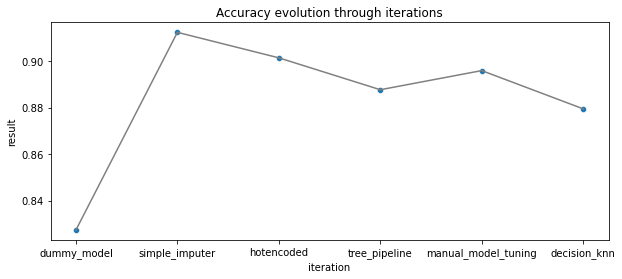

In [80]:
plt.figure(figsize=(10, 4))
results = results.append({'iteration':'decision_knn', 'result': decision_knn}, ignore_index=True)
sns.lineplot(data=results, x='iteration', y='result', color='grey')
sns.scatterplot(data=results, x='iteration', y='result')
plt.title('Accuracy evolution through iterations');